<a id="toc"></a>
# Deimos beamline spectral transmission

[rafael.celestre@synchrotron-soleil.fr](mailto:rafael.celestre@synchrotron-soleil.fr)

Contents :
1. [M1 system](#m1)
1. [Monochromator](#mono)
    1. [G1600](#G1600)
    1. [G2400](#G2400)
1. [Wolter focusing system](#wolter)
1. [Photon flux](#flux)
1. [Ideas for DEIMOS-II](#deimosii)
***

In [1]:
__author__ = ['Rafael Celestre']
__contact__ = 'rafael.celestre@synchrotron-soleil.fr'
__license__ = 'GPL-3.0'
__copyright__ = 'Synchrotron SOLEIL, Saint Aubin, France'
__created__ = '09/05/2024'
__changed__ = '21/10/2024'

import sys

import numpy as np
from barc4plots.barc4plots import PlotManager
from barc4xoc.grating import align_grating
from barc4xoc.aux_carpem import load_carpem_dataset
from barc4xoc.materials import reflectivity_curve, ml_reflectivity_curve
from barc4xoc.misc import energy_wavelength

# checking we are using the correct python:
print(sys.executable)
print(sys.version)


c:\Users\rafae\miniconda3\envs\PyOptiX\python.exe
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]


<a id="m1"></a>
## M1 system
[Back to the top](#toc)

Current mirrors have either Pt (M1A/M1B) or Rh (M1C) coatings. Incident angles are either $\theta=1.19°$ or 
$\theta=2.53°$.

In [2]:
e0, ei, ef, dE = 0, 250, 5000, 5
ne = int((ef-ei)/dE)+1
energy = np.linspace(ei, ef, ne)

In [3]:
Pt_1p19 = reflectivity_curve("Pt", -1, 1.19, ei, ef, ne)
Pt_2p53 = reflectivity_curve("Pt", -1, 2.53, ei, ef, ne)
Rh_1p20 = reflectivity_curve("Rh", -1, 1.19, ei, ef, ne)

Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Rh (Z=45): 12.410 g/cm3
f1f2_calc: using density: 12.410000 g/cm3


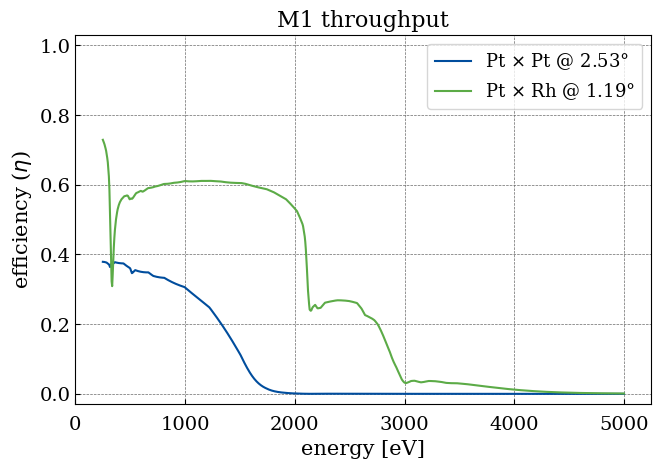

In [4]:
fig = PlotManager()

fig.image, fig.x = Pt_2p53["reflectivity"]**2, Pt_2p53["energy"]
fig.additional_info("M1 throughput", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, f'{Pt_2p53["material"]} $\\times$ {Pt_2p53["material"]} @ {Pt_2p53["theta"]:.2f}°').plot_1d(enable=False)
fig.image, fig.x = Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"], Pt_1p19["energy"]
fig.info_1d_plot(2, f'{Pt_1p19["material"]} $\\times$ {Rh_1p20["material"]} @ {Pt_1p19["theta"]:.2f}°').plot_1d(enable=True, hold=True)


<a id="mono"></a>
## Monochromator
[Back to the top](#toc)

Current Deimos monochromator system is a xxx monochromator composed of:

- two different plane gratings: G1600 (opperating at constant cff) and ML2400 (constant omega)
- M2A plane mirror (Pt coated) used with G1600
- M2B plane mirror (Mo2C/B4C ML)
- M3 cylindrical Pt coated mirror for vertical focusing onto the mono exit slits
- energy selecting slit (not considered here)

<a id="G1600"></a>
### G1600 monochromator
[Back to the top](#toc)

In order to reduce the variable space, simulations here are shown for a $cff=cos(\beta)/cos(\alpha)=0.2$. This grating has variable groove 
depth (VGD) ranging from 4nm to 16nm. We fix the VGD to 6 nm to simplify the calculations (compromise).

carpem_G1600_VGD40A_c0p20
carpem_G1600_VGD50A_c0p20
carpem_G1600_VGD60A_c0p20
carpem_G1600_VGD70A_c0p20
carpem_G1600_VGD80A_c0p20
carpem_G1600_VGD90A_c0p20


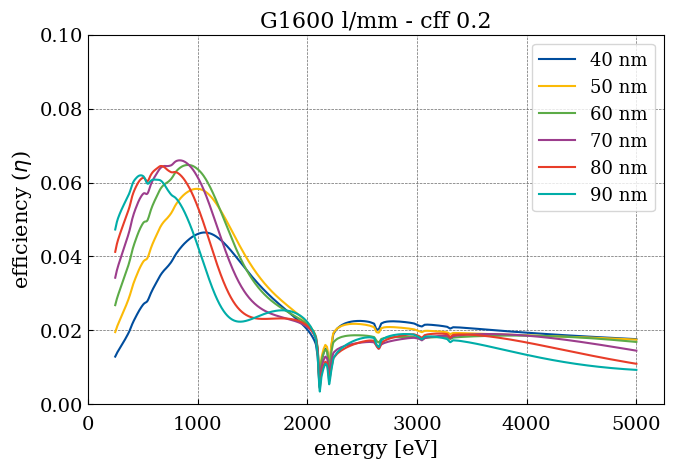

In [5]:
file_pattern = '.\\results\*c0p20'
G1600_cff0p2 = load_carpem_dataset(file_pattern)

vgd = np.arange(40, 100, 10)
grating = G1600_cff0p2
title = "G1600 l/mm - cff 0.2"

harmonic = "h1"
fig = PlotManager()
for i, (key, c) in enumerate(zip(grating.keys(), vgd)):
    print(key)
    fig.image, fig.x = grating[key][harmonic].values, energy
    fig.additional_info(title, "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=energy[-1]+(energy[0]-e0), ymin=0, ymax=.1).aesthetics(LaTex=True, grid=True)
    fig.info_1d_plot(i, f"{vgd[i]:.0f} nm", 1, "-").plot_1d(enable=(i == len(vgd) - 1), hold=(i != 0))

In [6]:
cff = [0.1, 0.2, 0.3, 0.5]

alpha_cff = np.zeros((len(energy), len(cff)))
beta_cff  = np.zeros((len(energy), len(cff)))
theta_cff = np.zeros((len(energy), len(cff)))
for j, c in enumerate(cff):
    for i, en in enumerate(energy):
        G1600 = align_grating(wavelength=energy_wavelength(en,"eV"),
                            line_density=1600e3,
                            order=1, 
                            condition="cff",
                            condition_value=c, 
                            verbose=0)
        
        alpha_cff[i,j] = G1600["alpha_deg"]
        beta_cff[i,j] = G1600["beta_deg"]
        theta_cff[i,j] = G1600["deviation_deg"]/2

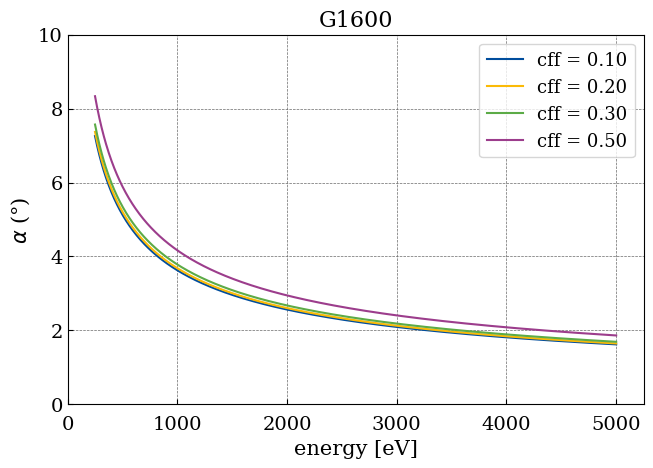

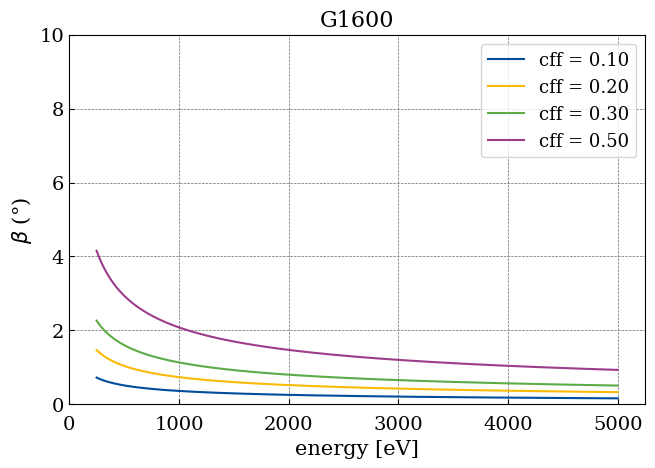

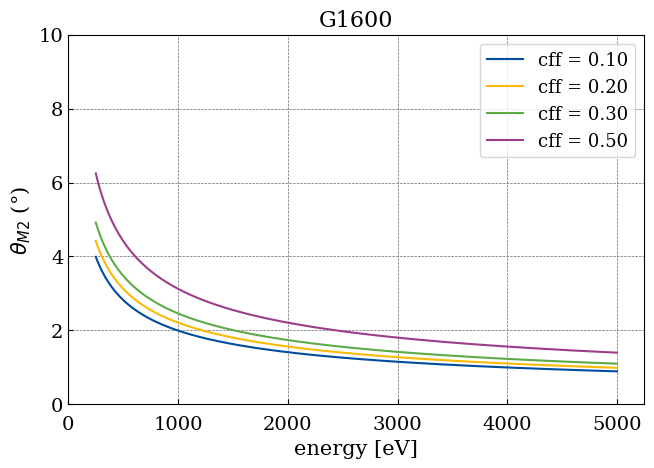

In [7]:
angle_label = ["$\\alpha$ (°)", "$\\beta$ (°)", "$\\theta_{M2}$ (°)"]
angle = [alpha_cff, beta_cff, theta_cff]
title = "G1600"

for lbl, agl in zip(angle_label, angle):
    fig = PlotManager()
    for i, c in enumerate(cff):
        fig.image, fig.x = agl[:, i], energy
        fig.additional_info(title, "energy [eV]", lbl, xmin=e0, xmax=energy[-1]+(energy[0]-e0), ymin=0, ymax=10).aesthetics(LaTex=True, grid=True)
        fig.info_1d_plot(i, f"cff = {cff[i]:.2f}", 1, "-").plot_1d(enable=(i == len(cff) - 1), hold=(i != 0))

#### Transmission

In [8]:
M2 = np.zeros(len(energy))
for i, en in enumerate(energy):
    reflec = reflectivity_curve("Pt", -1, theta_cff[i, 1], en, en, 1)
    M2[i] = reflec['reflectivity'][0]
M3 = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)

Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21

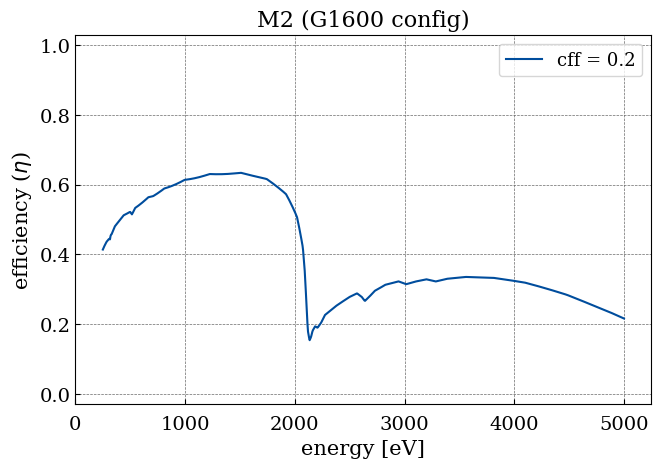

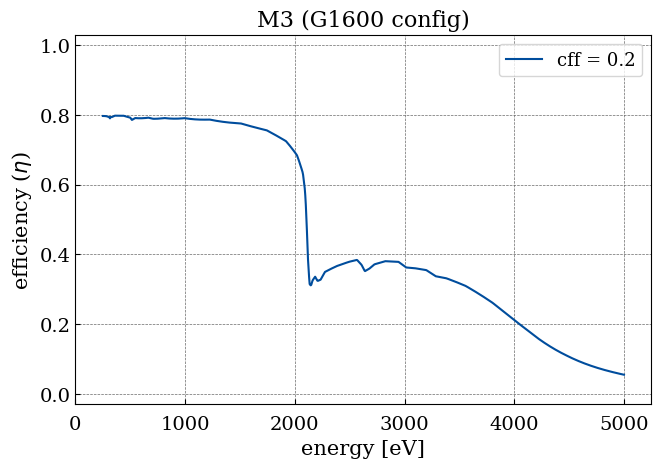

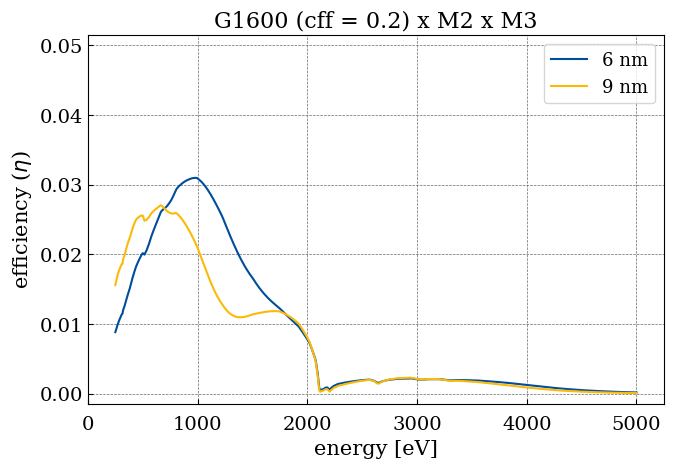

In [9]:
fig = PlotManager()
fig.image, fig.x = M2, energy
fig.additional_info("M2 (G1600 config)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'cff = 0.2').plot_1d(enable=True)

fig = PlotManager()
fig.image, fig.x = M3['reflectivity'], energy
fig.additional_info("M3 (G1600 config)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'cff = 0.2').plot_1d(enable=True)

fig = PlotManager()
fig.image, fig.x = G1600_cff0p2['carpem_G1600_VGD60A_c0p20']['h1'].values * M2 * M3['reflectivity'], energy
fig.additional_info("G1600 (cff = 0.2) x M2 x M3", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.0515).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, '6 nm').plot_1d(enable=False)
fig.image = G1600_cff0p2['carpem_G1600_VGD90A_c0p20']['h1'].values * M2 * M3['reflectivity']
fig.info_1d_plot(1, '9 nm').plot_1d(enable=True, hold=True)


<a id="G2400"></a>
### G2400 monochromator
[Back to the top](#toc)

We simulate the grating described in [1] and acompanying ML mirror (M2 - Mo2C/B4C):

The ML is composed of: B4C (26.4 A - odd layer/vacuum): Mo2C (27.22 A - even layer/substrate)
with $\Gamma=0.4923$.


[1] [Optics Letters Vol. 39, Issue 7, pp. 2141-2144 (2014)](https://doi.org/10.1364/OL.39.002141)



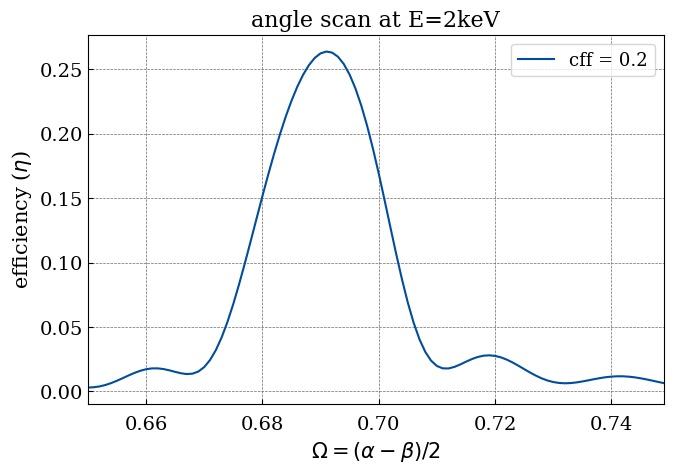

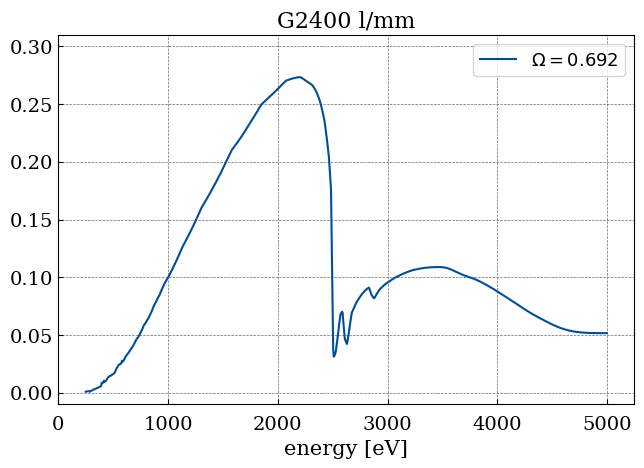

In [10]:
file_pattern = '.\\results\*omega_scan*small'
G2400_omega = load_carpem_dataset(file_pattern)
omega = (G2400_omega["carpem_G2400_ML_omega_scan2keV_small"]["alpha"]-G2400_omega["carpem_G2400_ML_omega_scan2keV_small"]["beta"])/2

fig = PlotManager()
fig.image, fig.x = G2400_omega["carpem_G2400_ML_omega_scan2keV_small"]["h1"], omega
fig.additional_info("angle scan at E=2keV", "$\Omega = (\\alpha-\\beta)/2$", "efficiency ($\eta$)").aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'cff = 0.2').plot_1d(enable=True)

file_pattern = '.\\results\*omega_0.692'
G2400_omega = load_carpem_dataset(file_pattern)
fig = PlotManager()
fig.image, fig.x = G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"], energy
fig.additional_info("G2400 l/mm", "energy [eV]", xmin=e0, xmax=ef+(ei-e0), ymin=-0.01, ymax=0.31).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, "$\Omega=0.692$").plot_1d(enable=True)

In [11]:
omega = 0.692

alpha_omg = np.zeros((len(energy)))
beta_omg  = np.zeros((len(energy)))
theta_omg = np.zeros((len(energy)))

for i, en in enumerate(energy):
    G2400 = align_grating(wavelength=energy_wavelength(en,"eV"),
                        line_density=2400e3,
                        order=1, 
                        condition="omega",
                        condition_value=np.radians(omega), 
                        verbose=0)
    
    alpha_omg[i] = G2400["alpha_deg"]
    beta_omg[i] = G2400["beta_deg"]
    theta_omg[i] = G2400["deviation_deg"]/2

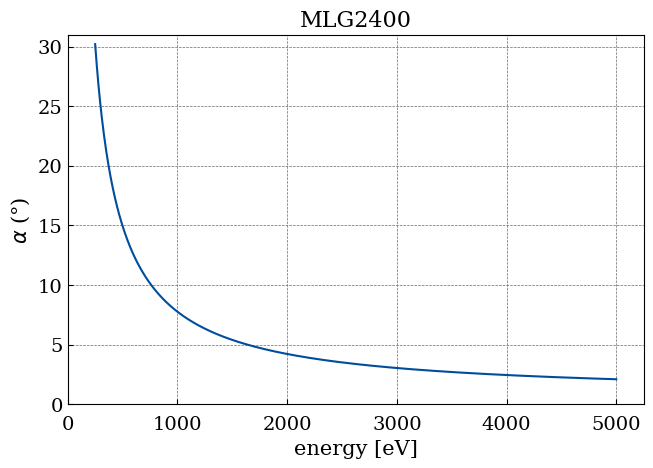

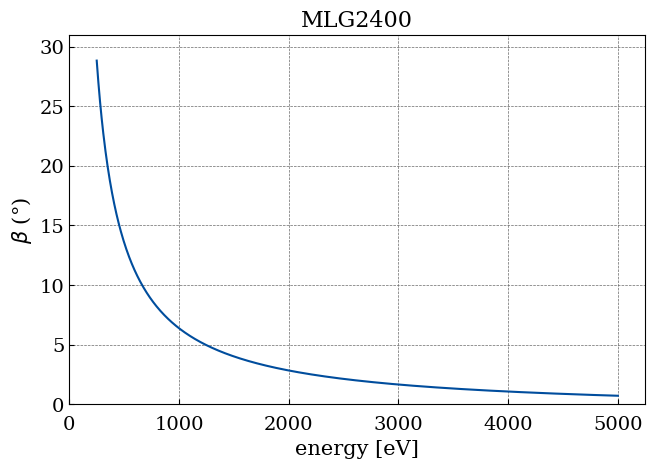

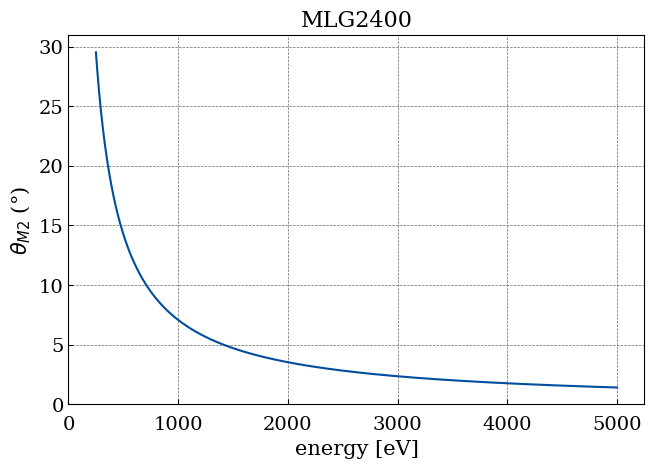

In [12]:
angle_label = ["$\\alpha$ (°)", "$\\beta$ (°)", "$\\theta_{M2}$ (°)"]
angle = [alpha_omg, beta_omg, theta_omg]
for lbl, agl in zip(angle_label, angle):
    grating = "MLG2400"   
    fig = PlotManager(agl, energy)
    fig.additional_info(grating, "energy [eV]", lbl, xmin=e0, xmax=energy[-1]+(energy[0]-e0), ymin=0, ymax=31).aesthetics(LaTex=True, grid=True)
    fig.info_1d_plot(0, None, 1, "-").plot_1d(enable=True, hold=False)

#### Transmission

In [13]:
M2ML = np.zeros(len(energy))
thickness_E = 24.8+2.42  # even layer is closer to the substrate
thickness_O = 24.8+1.6   # odd layer: closer to vacuum
print(thickness_E+thickness_O, thickness_E/(thickness_E+thickness_O))
for i, en in enumerate(energy):
    reflec = ml_reflectivity_curve(material_S="Si", density_S=2.33, roughness_S=0.0,
                                   material_E="Mo2C", density_E=9.18, roughness_E=0.0,
                                   material_O="B4C", density_O=2.52, roughness_O=0.0,
                                   bilayer_pairs=30,
                                   bilayer_thickness=thickness_E+thickness_O,
                                   bilayer_gamma=thickness_E/(thickness_E+thickness_O),    
                                   theta=theta_omg[i], ei=en, ef=en, ne=1)
    M2ML[i] = reflec['reflectivity'][0]


53.620000000000005 0.5076464005967922
------------------------------------------------------------------------
Inputs: 
   for E= 250.0 eV: 
   energy [eV]:                        250.0
   grazing angle [deg]:                29.522092531406685
   wavelength [A]:                     49.593679373280104
   wavenumber (2 pi/lambda) [cm^-1]:   12669326.790390989
Outputs: 
   R_S:                           0.06550109928799767
   R_P:                           0.03425906316230713
------------------------------------------------------------------------
------------------------------------------------------------------------
Inputs: 
   for E= 255.0 eV: 
   energy [eV]:                        255.0
   grazing angle [deg]:                28.88787974572844
   wavelength [A]:                     48.62125428752951
   wavenumber (2 pi/lambda) [cm^-1]:   12922713.326198809
Outputs: 
   R_S:                           0.07482426847730839
   R_P:                           0.04029459083947846
-----------

C:\Users\rafae\AppData\Local\Temp\ipykernel_19824\514823267.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M2ML[i] = reflec['reflectivity'][0]


------------------------------------------------------------------------
Inputs: 
   for E= 1175.0 eV: 
   energy [eV]:                        1175.0
   grazing angle [deg]:                6.01808468835699
   wavelength [A]:                     10.551846675165981
   wavenumber (2 pi/lambda) [cm^-1]:   59545835.91483764
Outputs: 
   R_S:                           0.5840750155849099
   R_P:                           0.5774813963170534
------------------------------------------------------------------------
------------------------------------------------------------------------
Inputs: 
   for E= 1180.0 eV: 
   energy [eV]:                        1180.0
   grazing angle [deg]:                5.992490738600531
   wavelength [A]:                     10.507135460440699
   wavenumber (2 pi/lambda) [cm^-1]:   59799222.45064547
Outputs: 
   R_S:                           0.5856325423793473
   R_P:                           0.5791021275480609
----------------------------------------------------

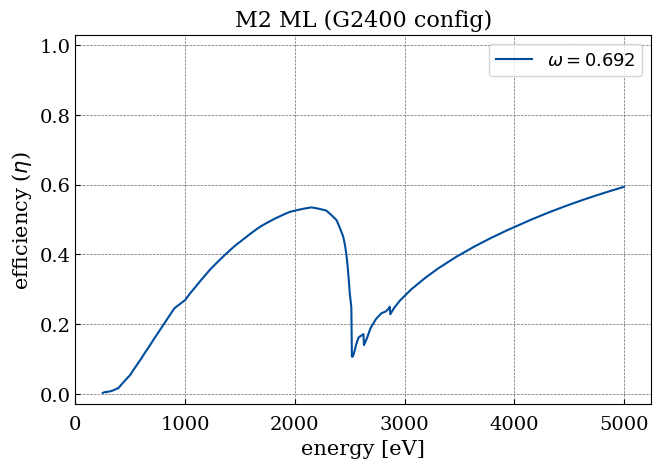

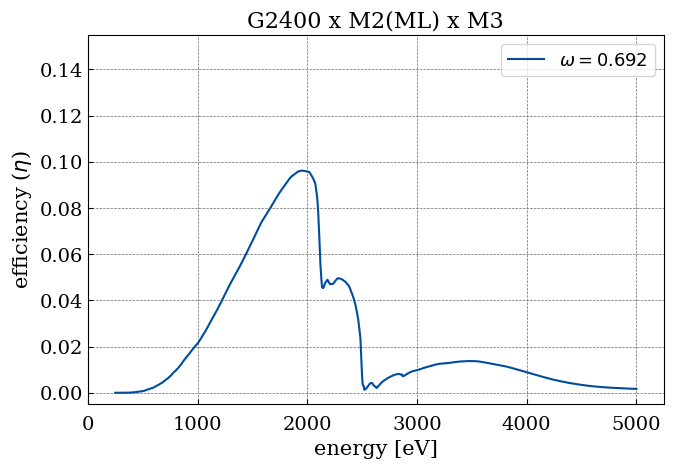

In [14]:
fig = PlotManager()
fig.image, fig.x = M2ML, energy
fig.additional_info("M2 ML (G2400 config)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, '$\omega=0.692$').plot_1d(enable=True)

fig = PlotManager()
fig.image, fig.x = G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3['reflectivity'], energy
fig.additional_info("G2400 x M2(ML) x M3", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.005, ymax=0.155).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, '$\omega=0.692$').plot_1d(enable=True)


<a id="wolter"></a>
## Wolter focusing system
[Back to the top](#toc)

Both Wolter mirror are coated with Pt and are at a $\theta=1.2°$:

Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3


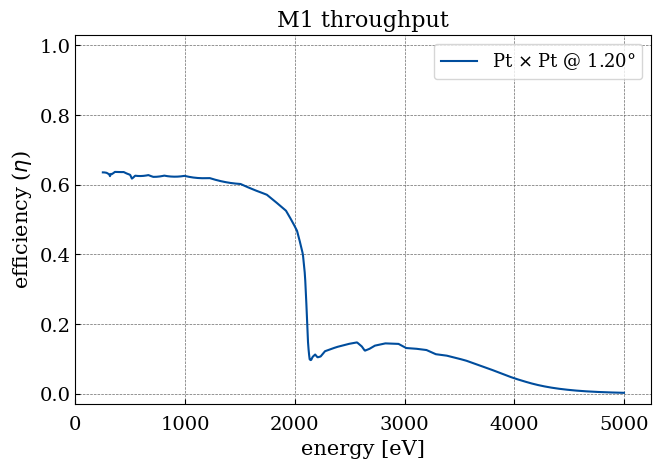

In [15]:
Wolter = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)

fig = PlotManager()

fig.image, fig.x = Wolter["reflectivity"]**2, Wolter["energy"]
fig.additional_info("M1 throughput", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, f'{Wolter["material"]} $\\times$ {Wolter["material"]} @ {Wolter["theta"]:.2f}°').plot_1d(enable=True)

<a id="flux"></a>
## Full beamline transmission
[Back to the top](#toc)

In [16]:
LEG1600 = (Pt_2p53["reflectivity"]*Pt_2p53["reflectivity"]*
           G1600_cff0p2['carpem_G1600_VGD60A_c0p20']['h1'].values * M2 * M3['reflectivity']*
           Wolter["reflectivity"]*Wolter["reflectivity"])

HEG1600 = (Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"]*
           G1600_cff0p2['carpem_G1600_VGD60A_c0p20']['h1'].values * M2 * M3['reflectivity']*
           Wolter["reflectivity"]*Wolter["reflectivity"])

# LEG2400 = (Pt_2p53["reflectivity"]*Pt_2p53["reflectivity"]*
#            G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3['reflectivity']*
#            Wolter["reflectivity"]*Wolter["reflectivity"])

HEG2400 = (Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"]*
           G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3['reflectivity']*
           Wolter["reflectivity"]*Wolter["reflectivity"])


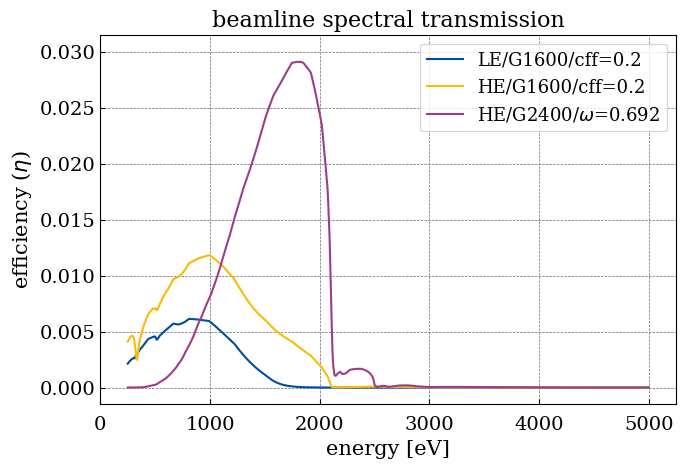

In [17]:
fig = PlotManager()
fig.image, fig.x = LEG1600, energy
fig.additional_info("beamline spectral transmission", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.0315).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'LE/G1600/cff=0.2').plot_1d(enable=False)
fig.image = HEG1600
fig.info_1d_plot(1, 'HE/G1600/cff=0.2').plot_1d(enable=False, hold=True)
# fig.image = LEG2400
# fig.info_1d_plot(2, 'LE/G2400/$\omega$=0.692').plot_1d(enable=False, hold=True)
fig.image = HEG2400
fig.info_1d_plot(3, 'HE/G2400/$\omega$=0.692').plot_1d(enable=True, hold=True)

### Transmitted photon flux

<a id="deimosii"></a>
## Ideas for DEIMOS-II
[Back to the top](#toc)

## Low energy (mono exit)

molarMass: 55.25
f1f2_calc_mix: Zs:  (5, 6)  n:  [4. 1.]
molarMass: 55.25
f1f2_calc_mix: Zs:  (5, 6)  n:  [4. 1.]


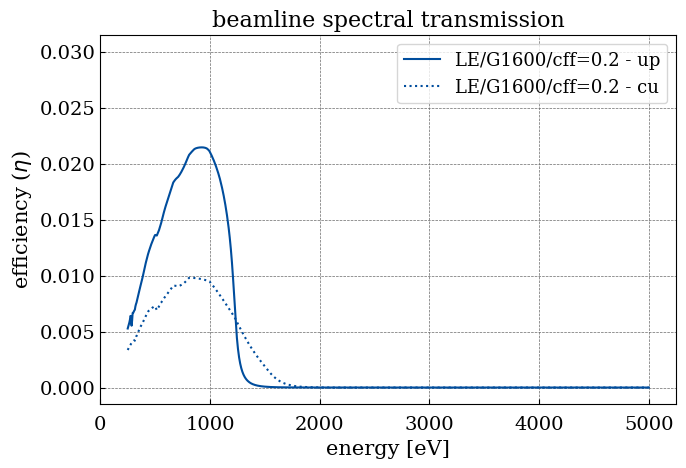

In [18]:
theta=1.5

LEG1600_cu = (Pt_2p53["reflectivity"]*Pt_2p53["reflectivity"]*
              G1600_cff0p2['carpem_G1600_VGD60A_c0p20']['h1'].values * M2 * M3['reflectivity']*1)
        #    Wolter["reflectivity"]*Wolter["reflectivity"])



M1A_le = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1B_le = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
# M1B_le = reflectivity_curve("Pt", -1, theta, ei, ef, ne)


LEG1600_up = (M1A_le["reflectivity"]*M1B_le["reflectivity"]*
              G1600_cff0p2['carpem_G1600_VGD60A_c0p20']['h1'].values * M2 * M3['reflectivity']*1)
        #    Wolter["reflectivity"]*Wolter["reflectivity"])

fig = PlotManager()
fig.image, fig.x = LEG1600_up, energy
fig.additional_info("beamline spectral transmission", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.0315).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'LE/G1600/cff=0.2 - up').plot_1d(enable=False)
fig.image = LEG1600_cu
fig.info_1d_plot(0, 'LE/G1600/cff=0.2 - cu', LineStyle=':').plot_1d(enable=True, hold=True)

## High energy energy

Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
molarMass: 55.25
f1f2_calc_mix: Zs:  (5, 6)  n:  [4. 1.]
molarMass: 55.25
f1f2_calc_mix: Zs:  (5, 6)  n:  [4. 1.]
molarMass: 55.25
f1f2_calc_mix: Zs:  (5, 6)  n:  [4. 1.]
molarMass: 55.25
f1f2_calc_mix: Zs:  (5, 6)  n:  [4. 1.]


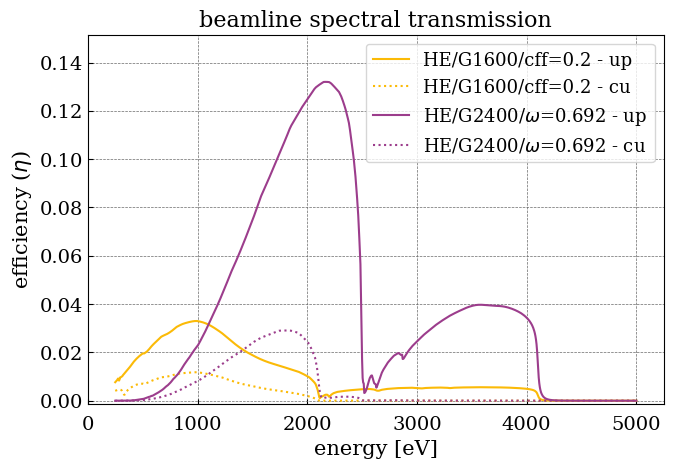

In [24]:
M3 = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)
Wolter = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)

HEG1600_cu = (Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"]*
              G1600_cff0p2['carpem_G1600_VGD60A_c0p20']['h1'].values * M2 * M3['reflectivity']* 
              Wolter["reflectivity"]*Wolter["reflectivity"])

HEG2400_cu = (Pt_1p19["reflectivity"]*Rh_1p20["reflectivity"]*
              G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3['reflectivity']*
              Wolter["reflectivity"]*Wolter["reflectivity"])

theta=0.44

M1A_he = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M1C_he = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
M3 = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)
Wolter = reflectivity_curve("B4C", 2.52, theta, ei, ef, ne)

HEG1600_up = (M1A_he["reflectivity"]*M1C_he["reflectivity"]*
              G1600_cff0p2['carpem_G1600_VGD60A_c0p20']['h1'].values * M2 * M3['reflectivity']* 
              Wolter["reflectivity"]*Wolter["reflectivity"])

HEG2400_up = (M1A_he["reflectivity"]*M1C_he["reflectivity"]*
              G2400_omega["carpem_G2400_ML_omega_0.692"]["h1"].values * M2ML * M3['reflectivity']*
              Wolter["reflectivity"]*Wolter["reflectivity"])

fig = PlotManager()
fig.image, fig.x = HEG1600_up, energy
fig.additional_info("beamline spectral transmission", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.1515).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(1, 'HE/G1600/cff=0.2 - up').plot_1d(enable=False)
fig.image = HEG1600_cu
fig.info_1d_plot(1, 'HE/G1600/cff=0.2 - cu', LineStyle=':').plot_1d(enable=False, hold=True)
fig.image = HEG2400_up
fig.info_1d_plot(3, 'HE/G2400/$\omega$=0.692 - up', LineStyle='-').plot_1d(enable=False, hold=True)
fig.image = HEG2400_cu
fig.info_1d_plot(3, 'HE/G2400/$\omega$=0.692 - cu', LineStyle=':').plot_1d(enable=True, hold=True)


## Full beamline transmission

Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3
Density for Pt (Z=78): 21.450 g/cm3
f1f2_calc: using density: 21.450000 g/cm3


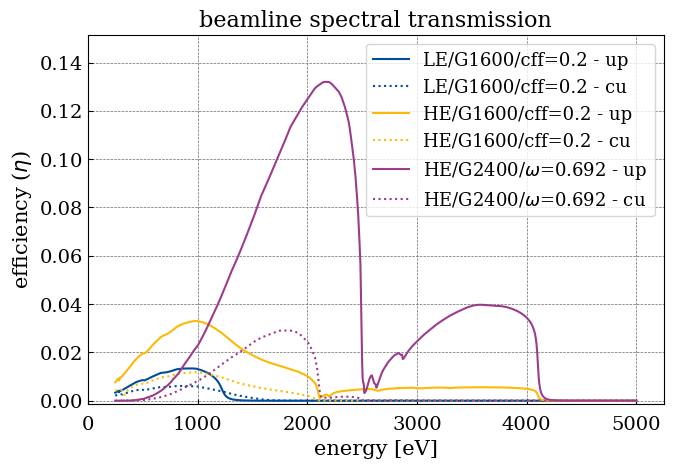

In [23]:
Wolter = reflectivity_curve("Pt", -1, 1.2, ei, ef, ne)
Wolter_up = reflectivity_curve("Pt", -1, theta, ei, ef, ne)

fig = PlotManager()
fig.image, fig.x = LEG1600_up*Wolter["reflectivity"]*Wolter["reflectivity"], energy
fig.additional_info("beamline spectral transmission", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.0015, ymax=0.1515).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, 'LE/G1600/cff=0.2 - up').plot_1d(enable=False)
fig.image = LEG1600_cu*Wolter["reflectivity"]*Wolter["reflectivity"]
fig.info_1d_plot(0, 'LE/G1600/cff=0.2 - cu', LineStyle=':').plot_1d(enable=False, hold=True)
fig.image= HEG1600_up
fig.info_1d_plot(1, 'HE/G1600/cff=0.2 - up', LineStyle='-').plot_1d(enable=False, hold=True)
fig.image = HEG1600_cu
fig.info_1d_plot(1, 'HE/G1600/cff=0.2 - cu', LineStyle=':').plot_1d(enable=False, hold=True)
fig.image = HEG2400_up
fig.info_1d_plot(3, 'HE/G2400/$\omega$=0.692 - up', LineStyle='-').plot_1d(enable=False, hold=True)
fig.image = HEG2400_cu
fig.info_1d_plot(3, 'HE/G2400/$\omega$=0.692 - cu', LineStyle=':').plot_1d(enable=True, hold=True)